In [1]:
from src.generate_data import Data
from src.evaluate import *
from src.models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [4]:
%%time
data = Data(layer_size=16, permutation_intervals=3)

# hack to get only third interval in train and all other intervals in test

train = data.samples[:400]
test = data.samples[1680:2583] + data.samples[-2*data.last_interval_size+52:]
data.samples = train+test
data.first_interval_size = 400
data.last_interval_size = len(data.samples) - data.first_interval_size
data.samples_char_sep = data.separate_string_chars(data.samples)
data.np_data = data.one_hot_encode(data.samples_char_sep)

C:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 453 ms
Wall time: 446 ms


In [5]:
%%time
train, val, test = data.get_splits(['1st_interval'], [])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 400 train | 363 val | 1456 test
CPU times: total: 78.1 ms
Wall time: 71.8 ms


#### Peek at unshuffled train data

In [6]:
train_original[:20]

[[',..._.._,.___._.', 'w,,_,.,_,__.._.,', 'cr__,._,._,._,__', False],
 [',___._.,_.,,..,_', 'w_.,.,._,_._..,,', ',cr,__,,._._.,,_', False],
 [',_..,__......___', 'w__.____,_,..___', '.,cr_.__._.,..._', False],
 ['_.,,.,....,__._,', 'w,.,.,.___,_,_,_', '.._cr_.___.,,,.,', False],
 [',.._.._,_...,.,_', 'w.__,,_,,_,__..,', '..,_cr_.,.,_.___', False],
 [',,.._.....,,,,,_', '_w,.._.,...,_.,_', 'cr...__..,__,_..', False],
 ['__....,,,._..,,.', '.w._.,.,__.,.__.', '.cr_..,_.,_,__.,', False],
 [',,,__..__.____,.', '_w__,_._,,.__,,.', '..cr.__,..,,__,.', False],
 ['..,._,.__.,__,,_', ',w,_,..__,_,_,..', '_,.cr_,__.._,___', False],
 [',.,.,,__,,._.,__', ',w,,_,.__..__,,,', '_,_,cr.,._____.,', False],
 [',__._,_.___._.,_', '..w.._,__.__.___', 'cr,,,,,__..._,,.', False],
 ['__,,._,..,,,._,_', '_.w___,.,,,.,,._', '_cr_..__.,.,,._.', False],
 ['_,,,,,._.,..,___', '.,w_.,_,__,.,__,', '.,cr..,.__...,..', False],
 [',,_._,._,.,....,', '..w,,,_____.,.._', '.,_cr,_,_._,,,..', False],
 ['.,....__,___,,_,'

In [7]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 25 | F2-uw 25 | F2-w 25 | F2-noop 25 | 
F3 cr:    F2-wu 25 | F2-uw 25 | F2-w 25 | F2-noop 25 | 
F3 r:    F2-wu 25 | F2-uw 25 | F2-w 25 | F2-noop 25 | 
F3 noop:    F2-wu 25 | F2-uw 25 | F2-w 25 | F2-noop 25 | 

Positive samples count: 175
Total samples count: 400
Positive class ratio: 0.4375


#### Peek at test data

In [8]:
test_original[:15]

[['.._...,._,_____,', '_._.__,_.,.,,uw.', '.,__.._dr_._,,,.', True],
 [',_,._,__,,_,_,.,', '_,._._..,w.,_,.,', '.,..____,_.__.,,', False],
 ['._.,,,,..,_..,__', '._,_.._,_.,,_.__', ',__,,_,,_,._.cr,', False],
 ['.,.,___.._,.,_.,', '._...,,__..w._..', '__._...,_.dr,__.', True],
 [',,,....______.._', '_,,._.___,.._uw,', '...._,,,,.___._.', False],
 [',.__,_,.,.,__._,', ',.,_.,_.,_.,...,', '.__..,_,,_cr_.,.', False],
 ['._,_.,._,_,.__._', '_,,,..wu,,_.,.,.', '_.___,,._,__r,..', True],
 ['._._,,,,___,._,.', '_..__w.,._.,_,,.', '.,,,.._r,,,_.._,', True],
 [',__,.._,,,_,.,,,', ',,,,_,.._wu.__._', '.,.,,___dr,_..,.', False],
 ['__._,__..,,.____', '._.,____._,..w_,', ',_,_,_,__.,,,,._', False],
 [',__,,...,..___.,', ',._.._,_____w__,', '___,.r,,._...,_,', True],
 [',.,__..,,.._,_.,', '._,,_,___.uw,.,,', '._.,_..__cr.,.,,', False],
 ['.,._.._..,,.._..', '__.__,.,.,_._,.,', ',__,,.__r._,.,__', True],
 [',_,__,._..,__.,.', '._,.._,___.w,,.,', '__.,__,.r..,_,_.', True],
 ['.._.,_,_._,._.__', '_,.,

In [9]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 73 | F2-uw 85 | F2-w 88 | F2-noop 97 | 
F3 cr:    F2-wu 74 | F2-uw 84 | F2-w 70 | F2-noop 90 | 
F3 r:    F2-wu 87 | F2-uw 86 | F2-w 103 | F2-noop 103 | 
F3 noop:    F2-wu 94 | F2-uw 99 | F2-w 102 | F2-noop 121 | 

Positive samples count: 649
Total samples count: 1456
Positive class ratio: 0.44574175824175827


#### Peek at val data

In [10]:
val_original[:15]

[['.,_..,_,,,,,,___', ',.,.,.,,_,__,___', '.,..,..._cr.,_,,', False],
 ['..___.,,.___,_._', '_..,..,wu.,,.__.', '__,___.,.,_,.._.', False],
 ['_,_._,..,.,,_.,.', ',_,,,._,.._..,._', '_,__.,,_,_cr_,.,', False],
 ['_.._.,__........', ',..,__.,.._..w._', '.,_._.,_.._,dr._', True],
 ['...,,,,,,,__._,,', ',._,,.,__.___.wu', '.__....,__r,_,__', True],
 [',,,_,.._,___..._', ',..,_,,._,.__.._', '___,_,.,r,__.__,', True],
 [',,__,,,_.,._..,,', '_,.,_,,_,,_._,.,', ',_.,,.,,,cr.,,,_', False],
 ['._,._..,__,__.__', ',.,._uw,_.....,_', '.,.,__..._cr_.,.', False],
 [',___.,.._,._,.__', '.._.,wu_.__,__.,', '._.,._.,__,.,_,,', False],
 [',_,__,_,._._._..', ',_,.._.__.,__wu_', ',._,._,,r____._,', True],
 ['_...__,..,_,.___', '___,,._,w__,.__.', ',___,,_,,,_.,.cr', False],
 ['.,....,,_._,._..', ',__.,_,,uw_,,,_,', '._.,,___._,r._,.', True],
 ['.._,_.._,,,,.,..', '__.__.,,,w,,_.,_', '____.,_.__cr,._.', False],
 ['.,.__.._.,,_,.,,', ',___.,,_,,.,,__,', '.._,,,.,_,,.dr,.', True],
 ['.....,..,,._.._.', '__.

In [11]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 27 | F2-uw 15 | F2-w 22 | F2-noop 23 | 
F3 cr:    F2-wu 26 | F2-uw 16 | F2-w 10 | F2-noop 30 | 
F3 r:    F2-wu 23 | F2-uw 24 | F2-w 18 | F2-noop 29 | 
F3 noop:    F2-wu 26 | F2-uw 21 | F2-w 30 | F2-noop 23 | 

Positive samples count: 154
Total samples count: 363
Positive class ratio: 0.42424242424242425


#### Send label arrays to device

In [12]:
y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
y_test = torch.from_numpy(y_test.astype(float)).float().to(device)

#### Get data in normal format (same as CNN format)

In [13]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [14]:
x_train_normal[0].shape

torch.Size([400, 128])

#### Get data in convolutional format, send to device

In [15]:
x_train_cnn = data.to_conv_format(x_train)
x_val_cnn = data.to_conv_format(x_val)
x_test_cnn = data.to_conv_format(x_test)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [16]:
x_train_cnn[0].shape

torch.Size([400, 128])

#### Get data in LSTM format, send to device

In [17]:
x_train_lstm = data.to_lstm_format(x_train, padding_left_size=2, padding_right_size=0)
x_val_lstm = data.to_lstm_format(x_val, padding_left_size=0, padding_right_size=2)
x_test_lstm = data.to_lstm_format(x_test, padding_left_size=0, padding_right_size=2)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [18]:
x_train_lstm[0].shape

torch.Size([400, 18, 8])

### Define training parameters

In [19]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100

experiment_name = "2nd_interval"

### Define training procedure for each model

In [20]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []
    best_accuracy = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break


        model.load_state_dict(torch.load(f'./{model_name}_model_TEMP_' + experiment_name))
    
        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original))
        precisions.append(get_precision_by_cases(model, x_test, y_test, test_original))
        recalls.append(get_recall_by_cases(model, x_test, y_test, test_original))
        f1_scores.append(get_f1_by_cases(precisions[-1], recalls[-1]))
        
        wrong_preds.append((f"Experimento {i}", get_wrong_predictions(model, x_test, y_test, test_original)))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model test accuracy:", accuracies[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test precision:", precisions[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test recall:", recalls[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test f1:", f1_scores[-1]['Overall'])


    
    return accuracies, precisions, recalls, f1_scores, wrong_preds, [train_losses, val_losses, train_accs, val_accs], model
    #return accuracies, precisions, wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [21]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1, cnn_wrong_preds, cnn_epoch_stats, model = train_models(
    CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.0001, data, 64, 128, 4, -1, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21832\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.926510989010989
1 / 20 models trained | Current model test precision: 0.8973607038123167
1 / 20 models trained | Current model test recall: 0.9429892141756548
1 / 20 models trained | Current model test f1: 0.9196093163035312
2 / 20 models trained | Current model test accuracy: 0.9326923076923077
2 / 20 models trained | Current model test precision: 0.8952654232424677
2 / 20 models trained | Current model test recall: 0.9614791987673343
2 / 20 models trained | Current model test f1: 0.9271916790490342
3 / 20 models trained | Current model test accuracy: 0.9429945054945055
3 / 20 models trained | Current model test precision: 0.9042857142857142
3 / 20 models trained | Current model test recall: 0.975346687211094
3 / 20 models trained | Current model test f1: 0.938472942920682
4 / 20 models trained | Current model test accuracy: 0.8997252747252747
4 / 20 models trained | Current model test precision: 0.911620294599018
4 / 20 models tr

In [22]:
%%time
lstm_accuracies, lstm_precision, lstm_recall, lstm_f1, lstm_wrong_preds, lstm_epoch_stats, model = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21832\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.9189560439560439
1 / 20 models trained | Current model test precision: 0.8910162002945509
1 / 20 models trained | Current model test recall: 0.9322033898305084
1 / 20 models trained | Current model test f1: 0.911144578313253
2 / 20 models trained | Current model test accuracy: 0.8907967032967034
2 / 20 models trained | Current model test precision: 0.8901273885350318
2 / 20 models trained | Current model test recall: 0.8613251155624037
2 / 20 models trained | Current model test f1: 0.87548942834769
3 / 20 models trained | Current model test accuracy: 0.907967032967033
3 / 20 models trained | Current model test precision: 0.8943338437978561
3 / 20 models trained | Current model test recall: 0.8998459167950693
3 / 20 models trained | Current model test f1: 0.8970814132104455
4 / 20 models trained | Current model test accuracy: 0.9498626373626373
4 / 20 models trained | Current model test precision: 0.8988919667590027
4 / 20 models tr

In [23]:
%%time
deepset_accuracies, deepset_procision, deepset_recall, deepset_f1, deepset_wrong_preds, deepset_epoch_stats, model = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.005, data, 128, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21832\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.5576923076923077
1 / 20 models trained | Current model test precision: 0.5301204819277109
1 / 20 models trained | Current model test recall: 0.06779661016949153
1 / 20 models trained | Current model test f1: 0.12021857923497267
2 / 20 models trained | Current model test accuracy: 0.5480769230769231
2 / 20 models trained | Current model test precision: 0.423728813559322
2 / 20 models trained | Current model test recall: 0.03852080123266564
2 / 20 models trained | Current model test f1: 0.07062146892655366
3 / 20 models trained | Current model test accuracy: 0.5364010989010989
3 / 20 models trained | Current model test precision: 0.4329896907216495
3 / 20 models trained | Current model test recall: 0.12942989214175654
3 / 20 models trained | Current model test f1: 0.19928825622775803
4 / 20 models trained | Current model test accuracy: 0.5384615384615384
4 / 20 models trained | Current model test precision: 0.4634920634920635
4 / 20 

In [24]:
%%time
deepsetv2_accuracies, deepsetv2_procision, deepsetv2_recall, deepsetv2_f1, deepsetv2_wrong_preds, deepsetv2_epoch_stats, model = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21832\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.44574175824175827
1 / 20 models trained | Current model test precision: 0.44574175824175827
1 / 20 models trained | Current model test recall: 1.0
1 / 20 models trained | Current model test f1: 0.6166270783847981
2 / 20 models trained | Current model test accuracy: 0.44574175824175827
2 / 20 models trained | Current model test precision: 0.44574175824175827
2 / 20 models trained | Current model test recall: 1.0
2 / 20 models trained | Current model test f1: 0.6166270783847981
3 / 20 models trained | Current model test accuracy: 0.44574175824175827
3 / 20 models trained | Current model test precision: 0.44574175824175827
3 / 20 models trained | Current model test recall: 1.0
3 / 20 models trained | Current model test f1: 0.6166270783847981
4 / 20 models trained | Current model test accuracy: 0.44574175824175827
4 / 20 models trained | Current model test precision: 0.44574175824175827
4 / 20 models trained | Current model test recall

In [25]:
%%time
feedforward_accuracies, feedforward_precision, feedforward_recall, feedforward_f1, feedforward_wrong_preds, feedforward_epoch_stats, model = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21832\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.5473901098901099
1 / 20 models trained | Current model test precision: 0.4657534246575342
1 / 20 models trained | Current model test recall: 0.10477657935285054
1 / 20 models trained | Current model test f1: 0.1710691823899371
2 / 20 models trained | Current model test accuracy: 0.5542582417582418
2 / 20 models trained | Current model test precision: 0.5
2 / 20 models trained | Current model test recall: 0.04468412942989214
2 / 20 models trained | Current model test f1: 0.08203677510608204
3 / 20 models trained | Current model test accuracy: 0.5364010989010989
3 / 20 models trained | Current model test precision: 0.4368932038834951
3 / 20 models trained | Current model test recall: 0.1386748844375963
3 / 20 models trained | Current model test f1: 0.21052631578947367
4 / 20 models trained | Current model test accuracy: 0.5350274725274725
4 / 20 models trained | Current model test precision: 0.35106382978723405
4 / 20 models trained 

# Evaluation

In [26]:
import pandas as pd
# Lista de modelos y nombres
model_names = ['CNN', 'LSTM', 'DeepSet', 'DeepSetV2', 'Feedforward']
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precision, deepset_procision, deepsetv2_procision, feedforward_precision]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1, lstm_f1, deepset_f1, deepsetv2_f1, feedforward_f1]

imprimirMetricas(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

        Modelo  Accuracy  Precision    Recall  F1-score
0          CNN  0.943681   0.902128  0.979969  0.939439
1         LSTM  0.949863   0.898892  1.000000  0.946754
2      DeepSet  0.557692   0.530120  0.067797  0.120219
3    DeepSetV2  0.445742   0.445742  1.000000  0.616627
4  Feedforward  0.554945   0.508772  0.044684  0.082153


### Get best 50% performing models

In [27]:
top_half = int(num_experiments / 2)
best_cnn_accs = filter_top_k_accuracies(cnn_accuracies, top_half)
best_lstm_accs = filter_top_k_accuracies(lstm_accuracies, top_half)
best_deepset_accs = filter_top_k_accuracies(deepset_accuracies, top_half)
best_deepsetv2_accs = filter_top_k_accuracies(deepsetv2_accuracies, top_half)
best_feedforward_accs = filter_top_k_accuracies(feedforward_accuracies, top_half)

## Accuracy breakdown by cases for all the models

In [28]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [29]:
get_stats_df(all_accuracies, model_names, test_original)

,Overall,cr_noop,cr_uw,cr_w,cr_wu,dr_noop,dr_uw,dr_w,dr_wu,noop_noop,noop_uw,noop_w,noop_wu,r_noop,r_uw,r_w,r_wu
CNN,89.7%,100.0%,100.0%,100.0%,100.0%,84.5%,81.6%,83.7%,23.8%,99.5%,99.7%,99.7%,99.9%,89.9%,87.9%,87.6%,83.7%
LSTM,86.7%,99.0%,99.3%,98.7%,99.3%,88.2%,84.4%,88.2%,26.0%,96.3%,97.2%,96.6%,97.2%,78.5%,76.5%,78.3%,73.6%
DeepSet(like in paper),53.6%,86.9%,86.1%,85.9%,85.8%,12.7%,11.5%,12.0%,85.3%,85.4%,86.5%,86.1%,87.2%,13.7%,11.5%,16.5%,12.7%
DeepSet(sum at start),44.6%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,100.0%
Feedforward,54.4%,91.6%,92.9%,89.3%,90.6%,8.0%,7.4%,7.0%,91.0%,90.3%,92.3%,91.1%,93.6%,10.4%,6.6%,10.6%,7.5%
Sample count,1456,90,84,70,74,97,85,88,73,121,99,102,94,103,86,103,87


## Accuracy breakdown by cases for top 50% of models

In [30]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['dr', 'r', 'cr', 'noop']

In [31]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN,92.9%,100.0%,75.3%,99.6%,95.4%
LSTM,92.9%,100.0%,80.9%,99.2%,91.0%
DeepSet(like in paper),54.8%,96.2%,23.0%,95.6%,4.0%
DeepSet(sum at start),44.6%,0.0%,78.7%,0.0%,100.0%
Feedforward,55.0%,94.2%,23.8%,94.7%,6.7%
Sample count,1456,318,343,416,379


In [32]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['r', 'cr', 'noop']

In [33]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,dr_noop,dr_uw,dr_w,dr_wu,f3_cr,f3_noop,f3_r
CNN,92.9%,93.6%,92.2%,94.1%,8.6%,100.0%,99.6%,95.4%
LSTM,92.9%,99.6%,97.2%,99.2%,15.1%,100.0%,99.2%,91.0%
DeepSet(like in paper),54.8%,3.8%,2.7%,2.8%,96.3%,96.2%,95.6%,4.0%
DeepSet(sum at start),44.6%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,100.0%
Feedforward,55.0%,5.5%,4.7%,4.7%,93.7%,94.2%,94.7%,6.7%
Sample count,1456,97,85,88,73,318,416,379


## Accuracies per CNN model

In [34]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,92.7%,100.0%,75.5%,100.0%,93.9%
CNN #1,93.3%,100.0%,74.6%,99.0%,98.2%
CNN #2,94.3%,100.0%,77.0%,99.8%,99.2%
CNN #3,90.0%,100.0%,70.3%,100.0%,88.4%
CNN #4,86.5%,100.0%,68.8%,100.0%,76.5%
CNN #5,93.5%,100.0%,75.2%,100.0%,97.4%
CNN #6,93.1%,100.0%,76.1%,100.0%,95.0%
CNN #7,81.4%,100.0%,53.4%,100.0%,70.7%
CNN #8,89.7%,100.0%,72.3%,100.0%,85.5%
CNN #9,87.7%,100.0%,68.5%,99.5%,81.8%


## Accuracies per LSTM model

In [35]:
get_stats_per_model(best_lstm_accs, ['LSTM #' + str(i) for i in range(len(best_lstm_accs))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,95.0%,100.0%,78.7%,100.0%,100.0%
LSTM #1,94.8%,100.0%,78.7%,100.0%,99.5%
LSTM #2,94.2%,100.0%,78.7%,99.8%,97.4%
LSTM #3,94.0%,100.0%,78.7%,96.4%,100.0%
LSTM #4,93.5%,100.0%,78.7%,100.0%,94.5%
LSTM #5,93.0%,100.0%,78.7%,100.0%,92.3%
LSTM #6,91.9%,100.0%,76.4%,97.8%,92.6%
LSTM #7,91.6%,100.0%,98.5%,100.0%,69.1%
LSTM #8,90.8%,100.0%,79.6%,100.0%,83.1%
LSTM #9,90.4%,100.0%,82.2%,98.1%,81.3%


## Accuracies per DeepSets V1 model

In [36]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,55.8%,95.9%,24.8%,94.5%,7.7%
DeepSet(like in paper) #1,54.8%,95.9%,23.0%,95.4%,4.5%
DeepSet(like in paper) #2,53.6%,87.4%,25.4%,85.8%,15.6%
DeepSet(like in paper) #3,53.8%,79.2%,34.1%,82.0%,19.5%
DeepSet(like in paper) #4,54.2%,90.9%,24.8%,92.3%,8.2%
DeepSet(like in paper) #5,51.4%,78.0%,28.6%,76.9%,21.9%
DeepSet(like in paper) #6,50.8%,67.3%,35.6%,69.2%,30.3%
DeepSet(like in paper) #7,54.3%,95.0%,23.3%,94.2%,4.2%
DeepSet(like in paper) #8,54.6%,95.0%,24.8%,91.1%,7.7%
DeepSet(like in paper) #9,54.7%,97.8%,21.6%,95.4%,3.7%


## Accuracies per DeepSets V2 model

In [37]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,44.6%,0.0%,78.7%,0.0%,100.0%
DeepSet(sum at start) #1,44.6%,0.0%,78.7%,0.0%,100.0%
DeepSet(sum at start) #2,44.6%,0.0%,78.7%,0.0%,100.0%
DeepSet(sum at start) #3,44.6%,0.0%,78.7%,0.0%,100.0%
DeepSet(sum at start) #4,44.6%,0.0%,78.7%,0.0%,100.0%
DeepSet(sum at start) #5,44.6%,0.0%,78.7%,0.0%,100.0%
DeepSet(sum at start) #6,44.6%,0.0%,78.7%,0.0%,100.0%
DeepSet(sum at start) #7,44.6%,0.0%,78.7%,0.0%,100.0%
DeepSet(sum at start) #8,44.6%,0.0%,78.7%,0.0%,100.0%
DeepSet(sum at start) #9,44.6%,0.0%,78.7%,0.0%,100.0%


## Accuracies per FeedForward model

In [38]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,54.7%,90.6%,24.5%,90.9%,12.4%
Feedforward #1,55.4%,96.2%,23.6%,96.6%,4.7%
Feedforward #2,53.6%,86.8%,28.3%,84.9%,14.5%
Feedforward #3,53.5%,94.3%,21.9%,91.1%,6.6%
Feedforward #4,53.0%,75.2%,35.0%,78.4%,22.7%
Feedforward #5,52.9%,79.9%,29.2%,84.4%,17.2%
Feedforward #6,54.5%,93.7%,25.1%,94.7%,4.0%
Feedforward #7,54.7%,96.5%,23.3%,93.0%,6.1%
Feedforward #8,54.9%,95.6%,22.7%,98.8%,1.8%
Feedforward #9,54.9%,93.4%,23.9%,94.7%,7.1%


# Training evolution

### CNN

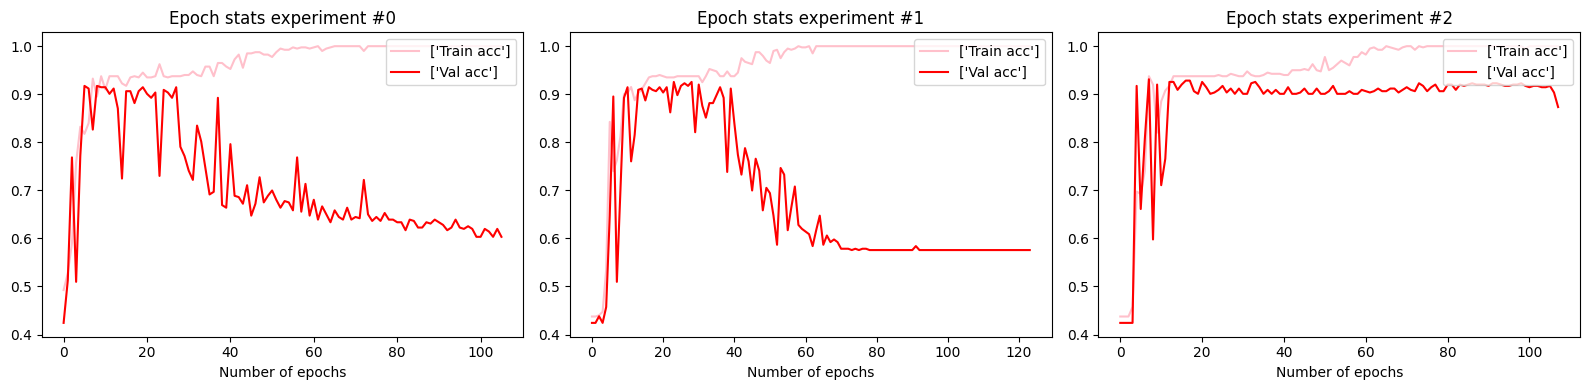

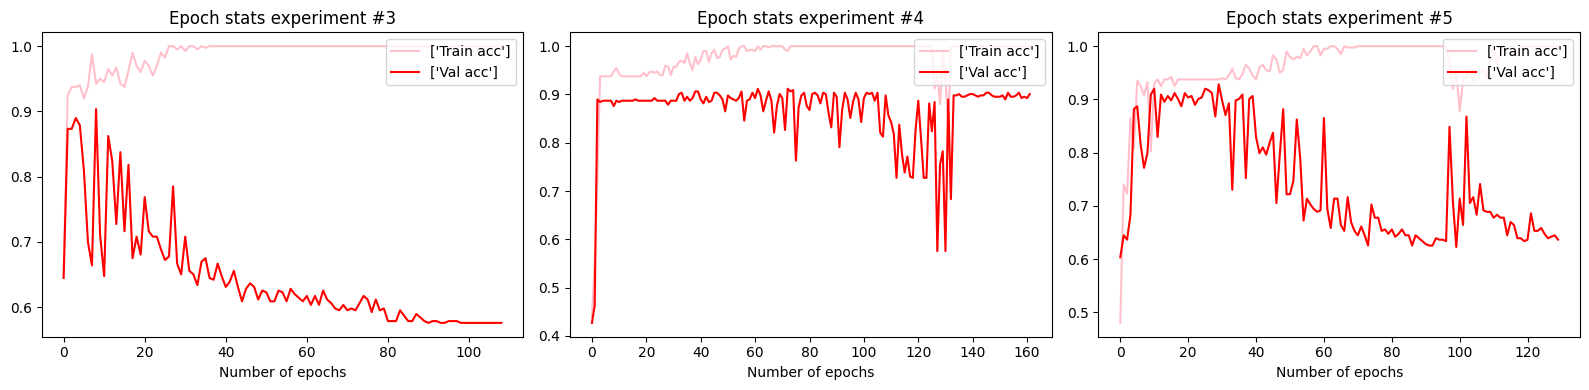

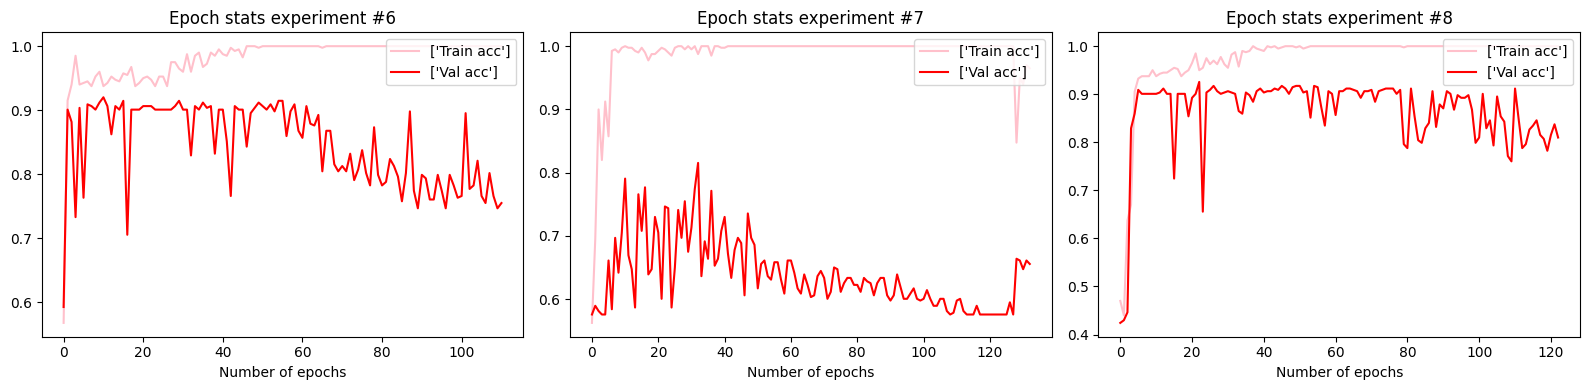

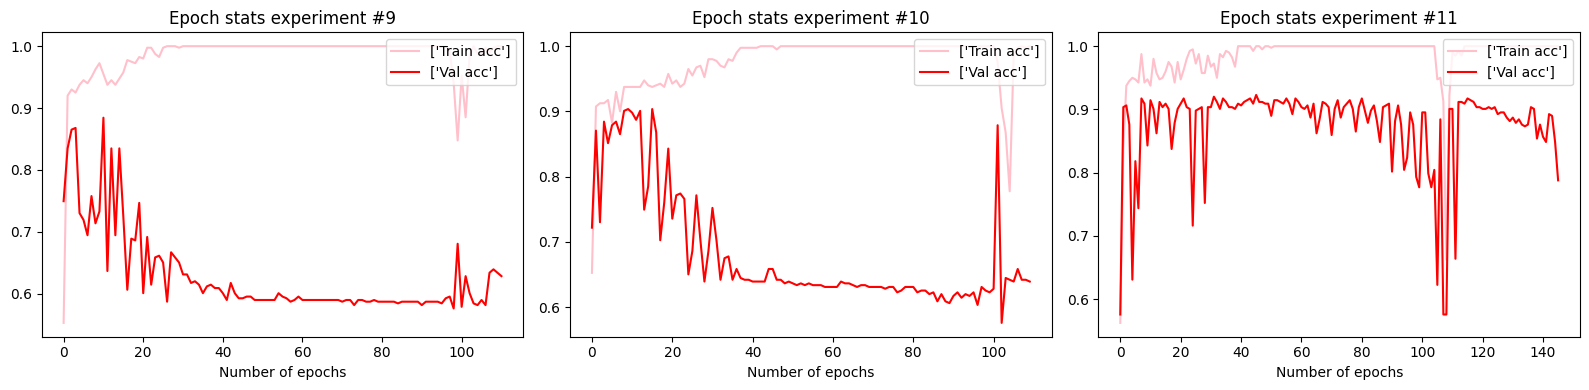

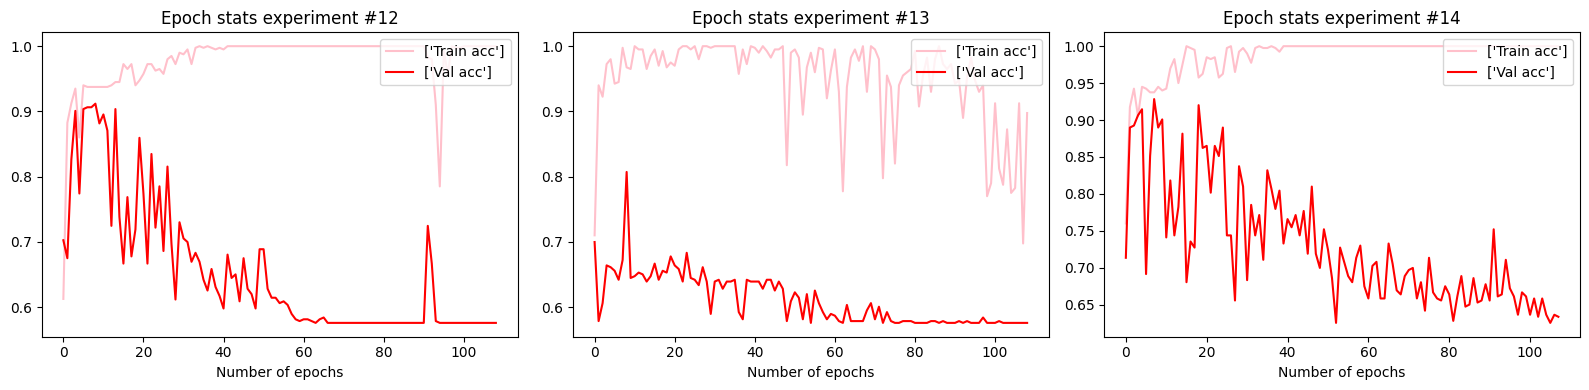

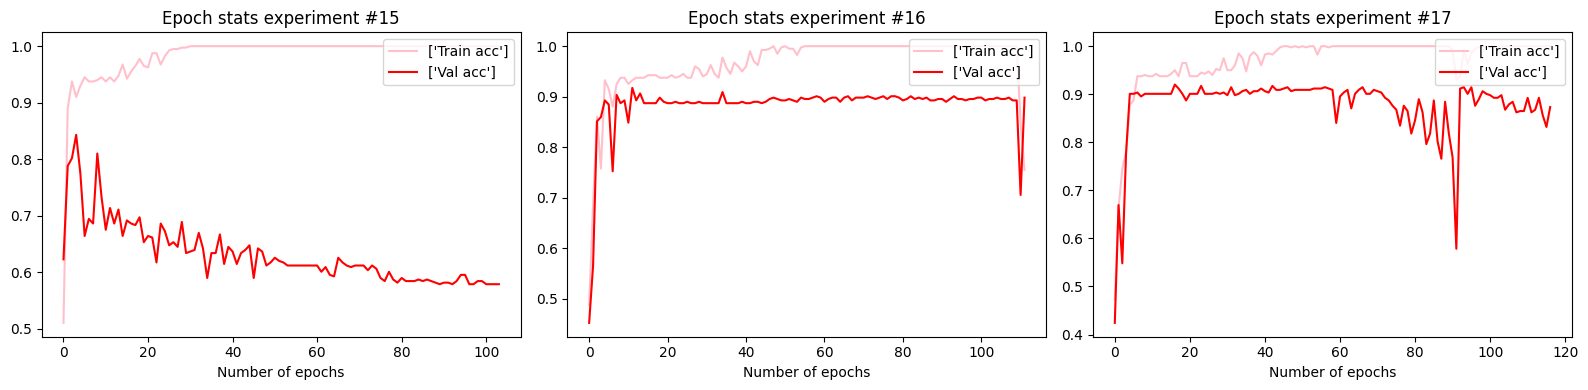

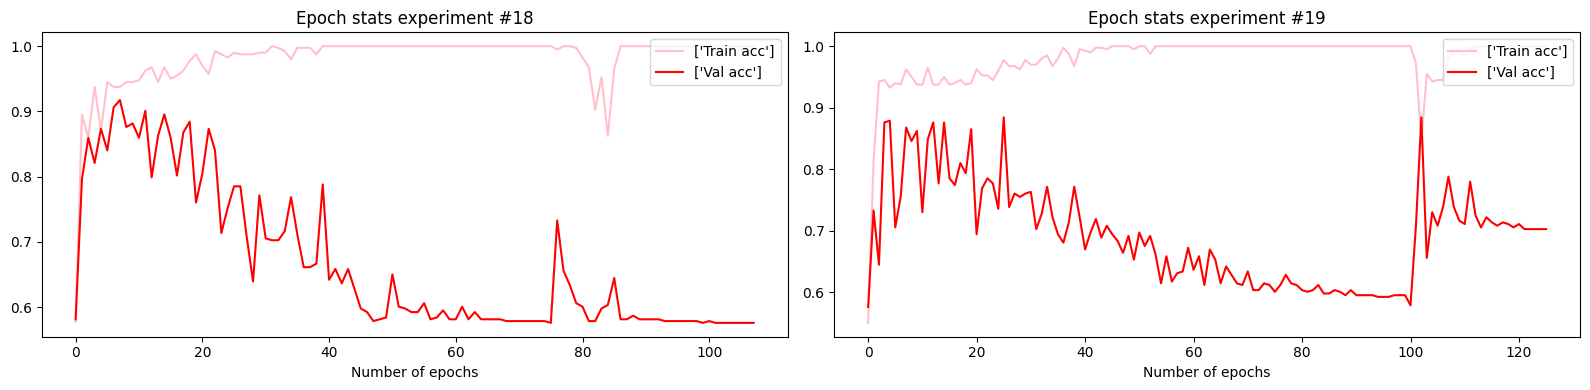

In [39]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

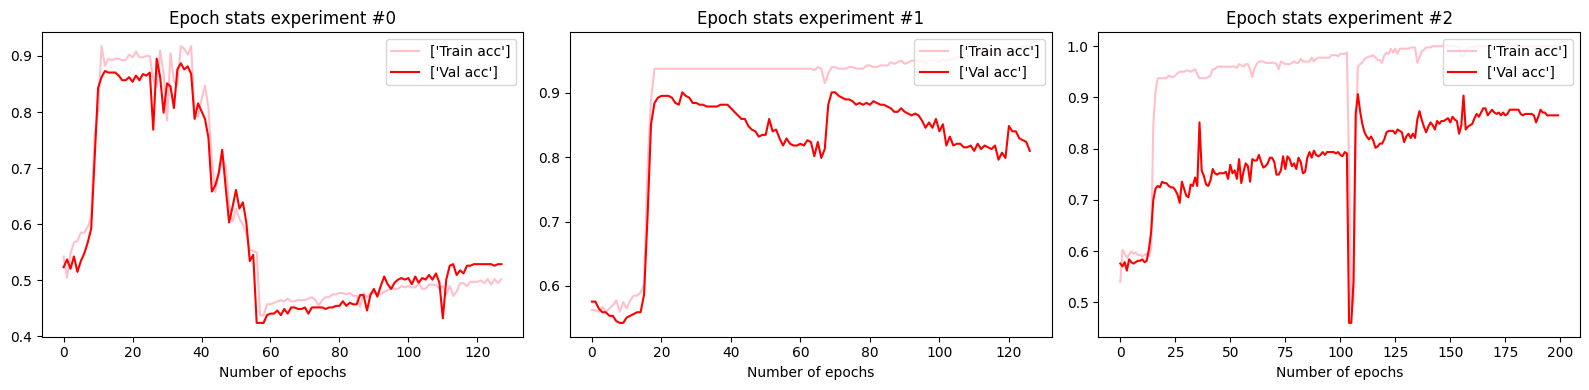

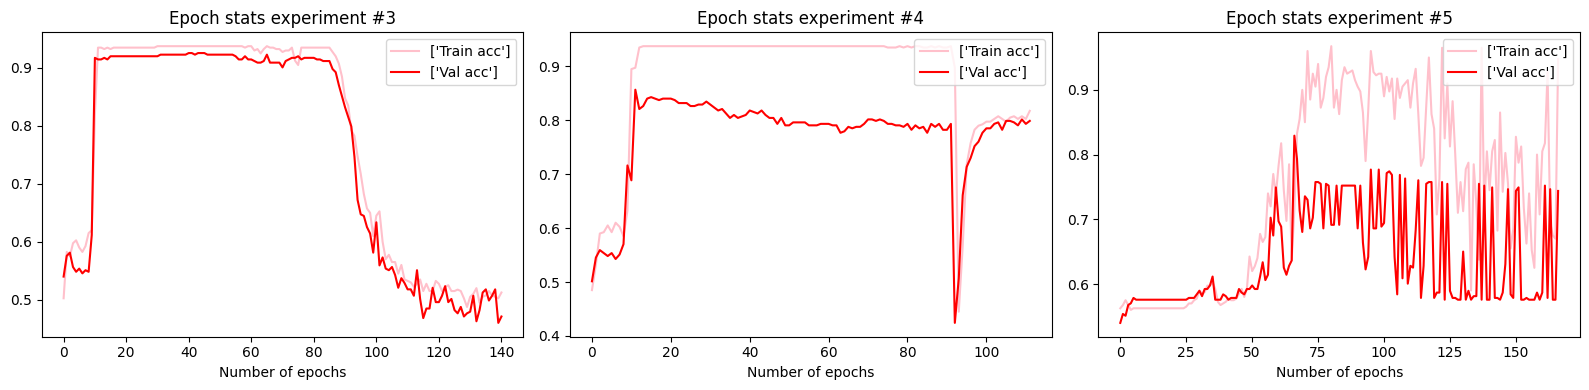

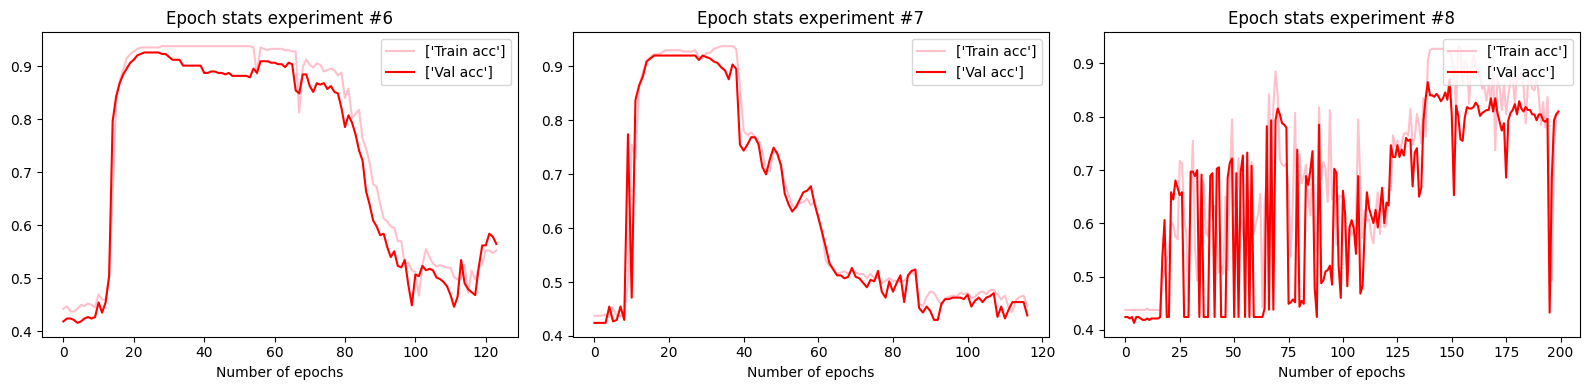

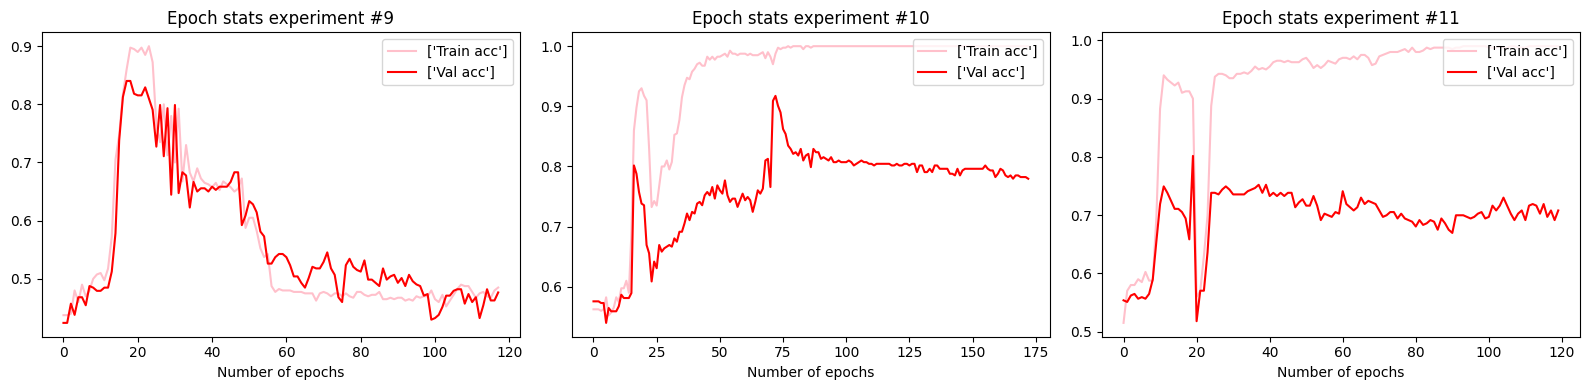

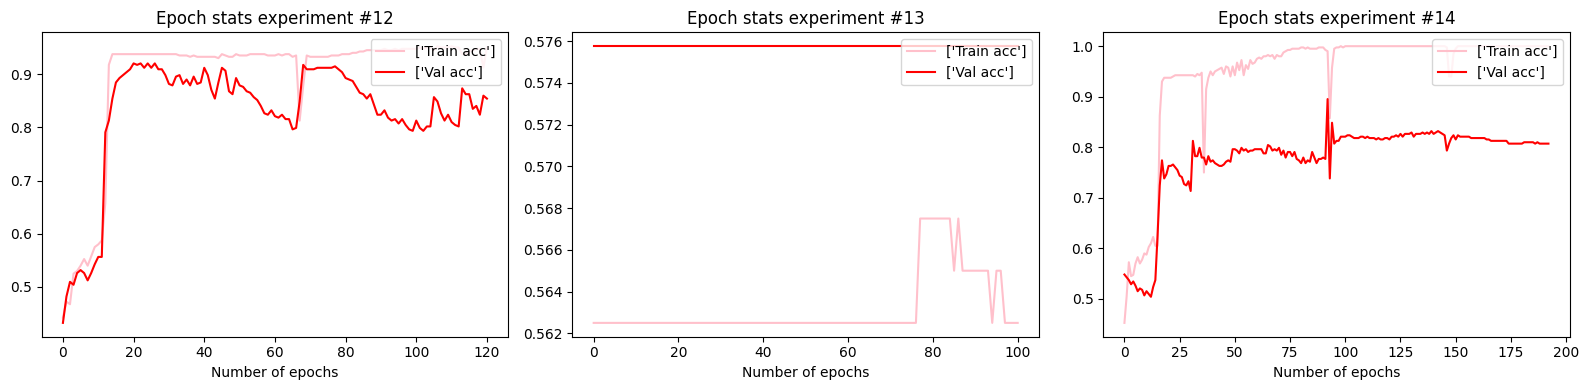

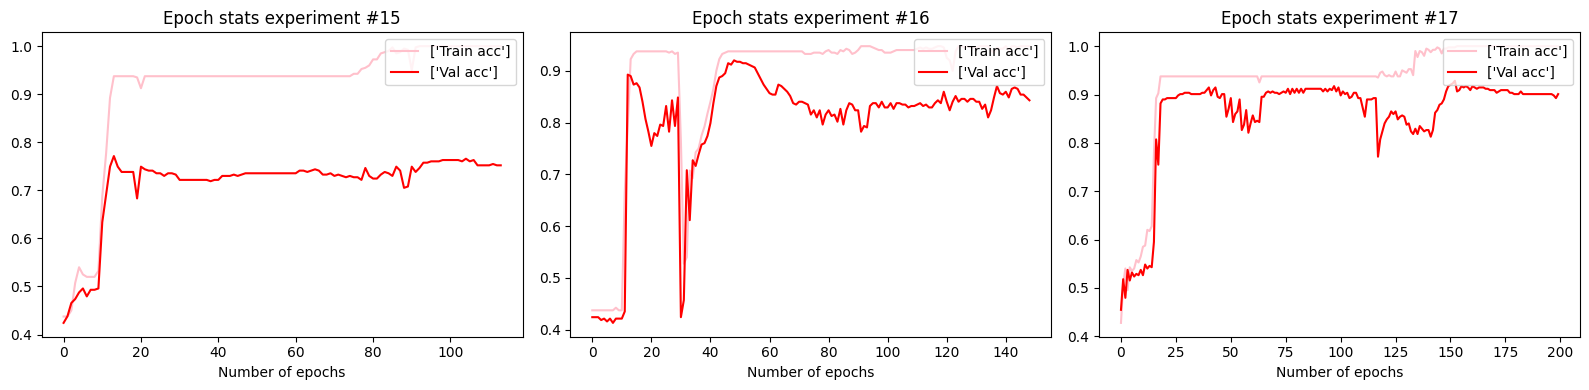

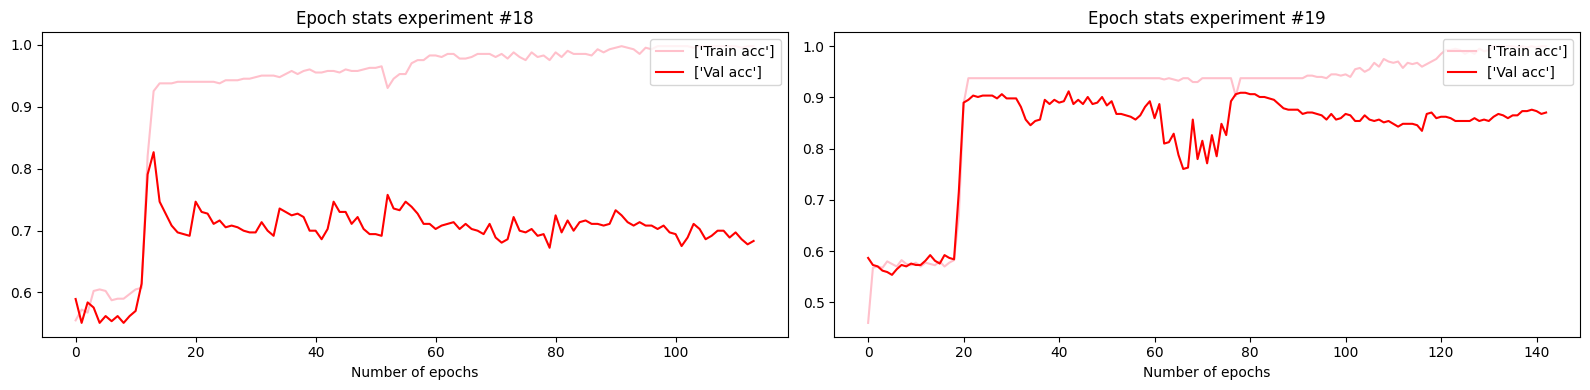

In [40]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

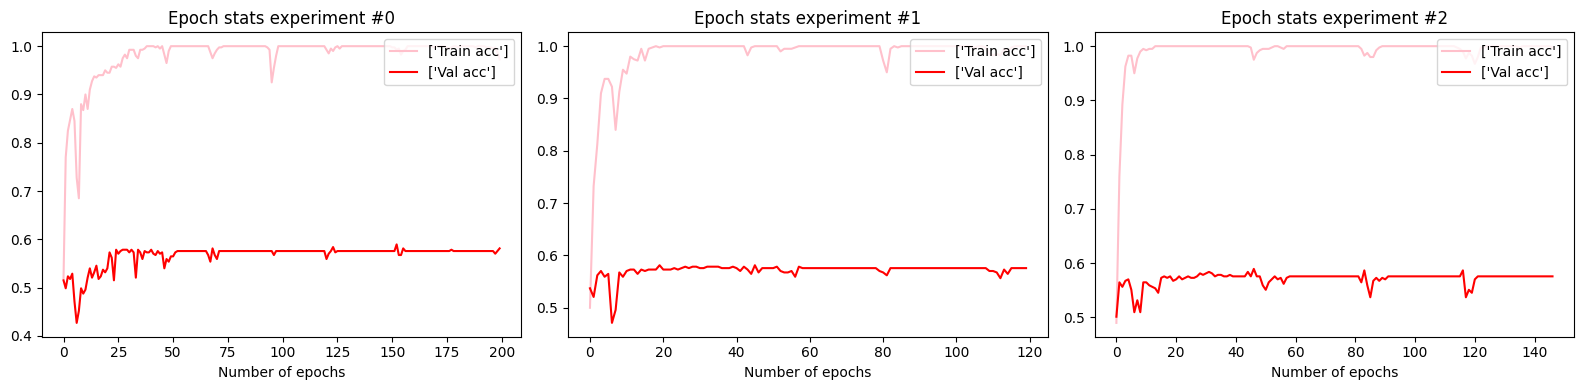

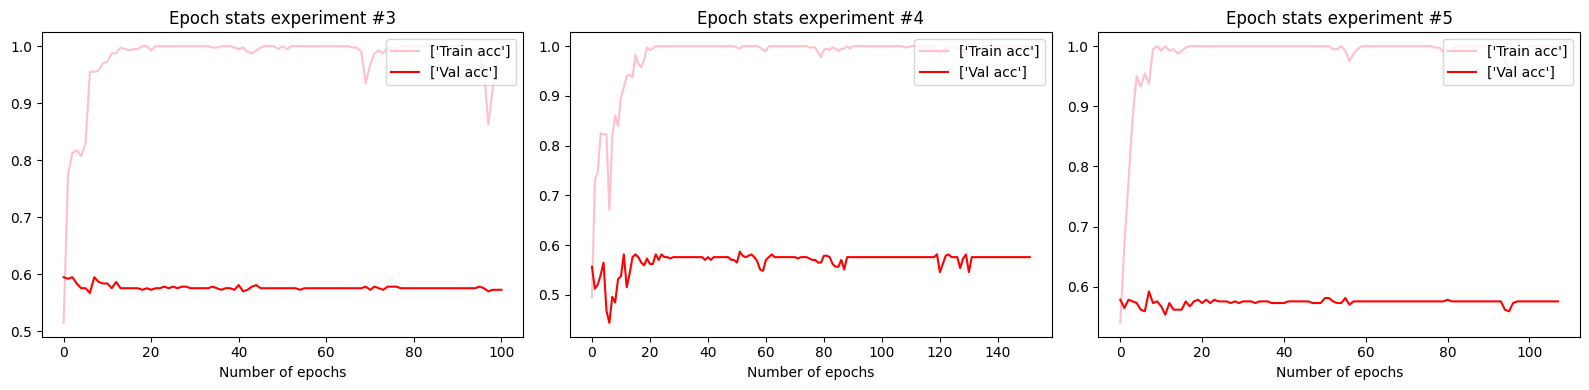

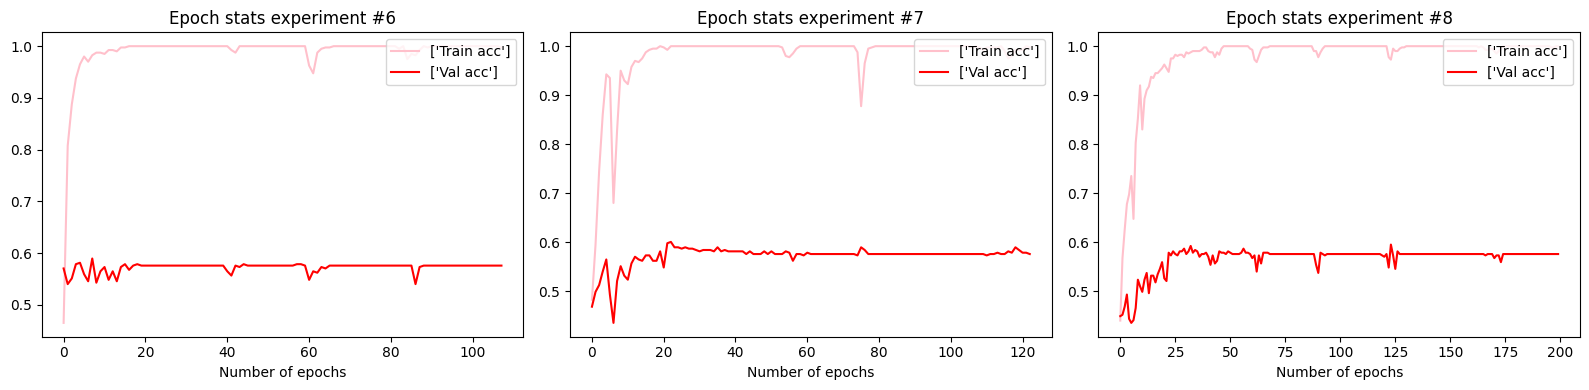

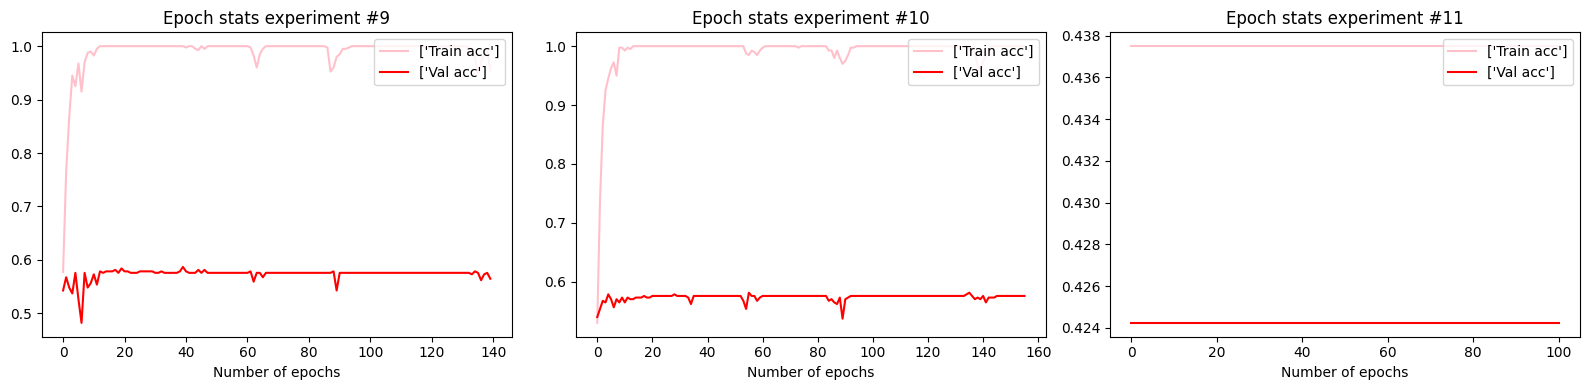

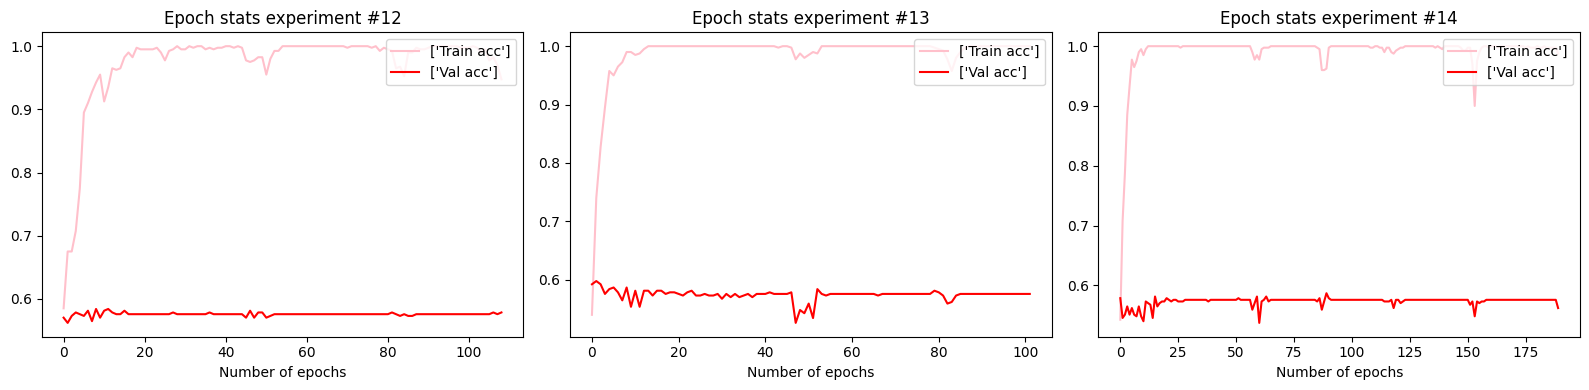

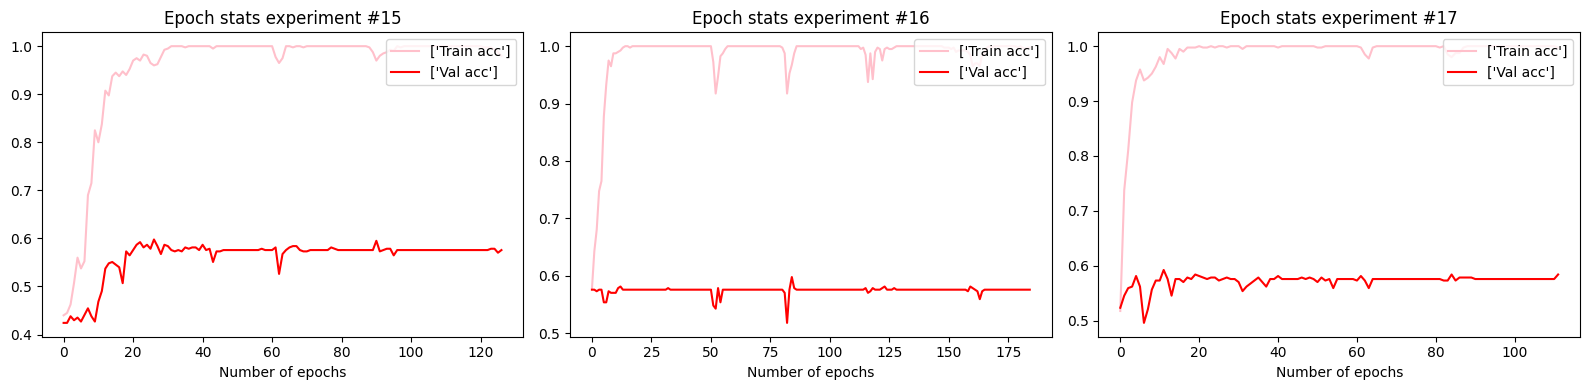

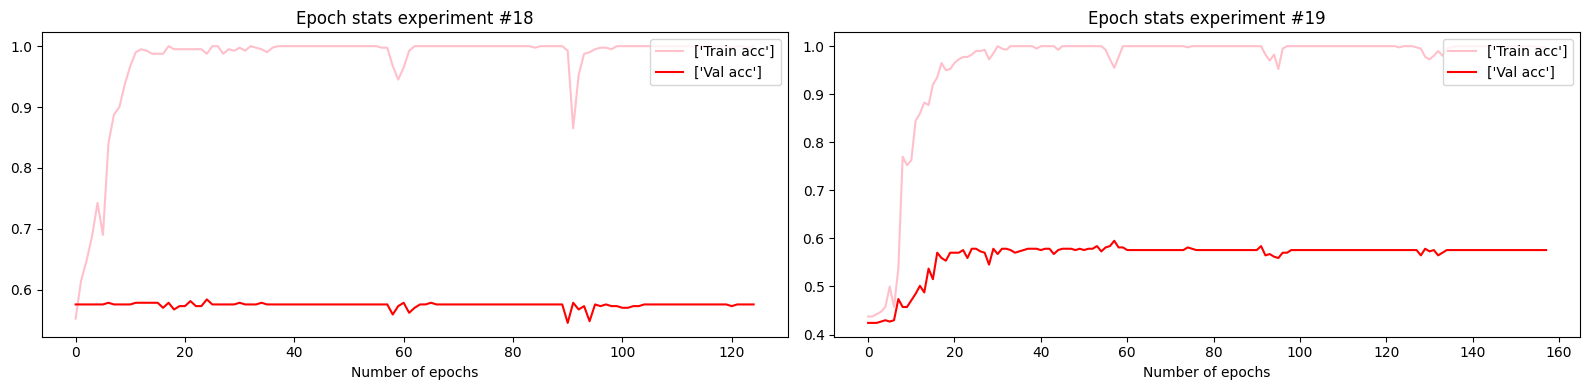

In [41]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

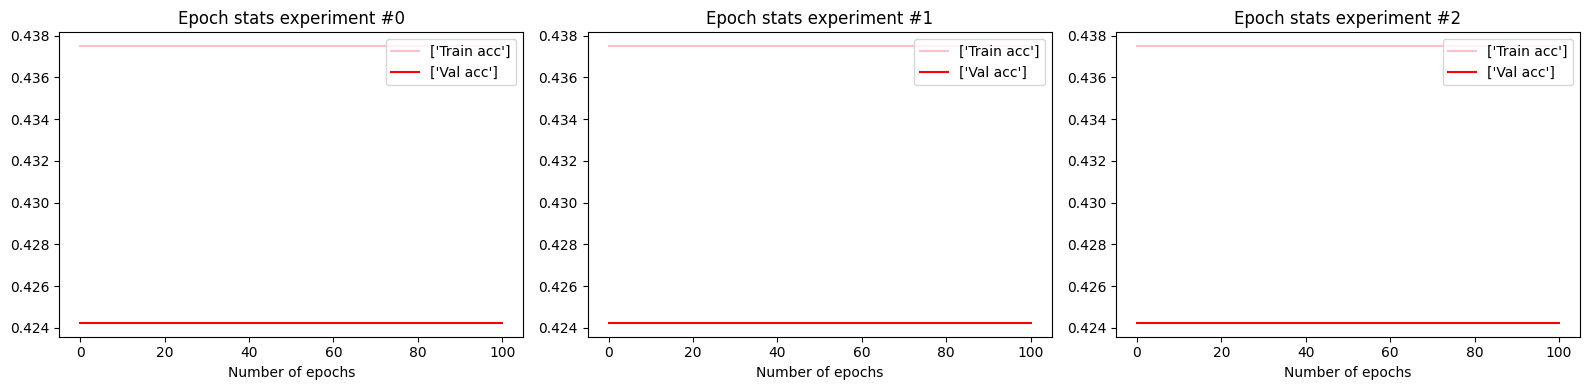

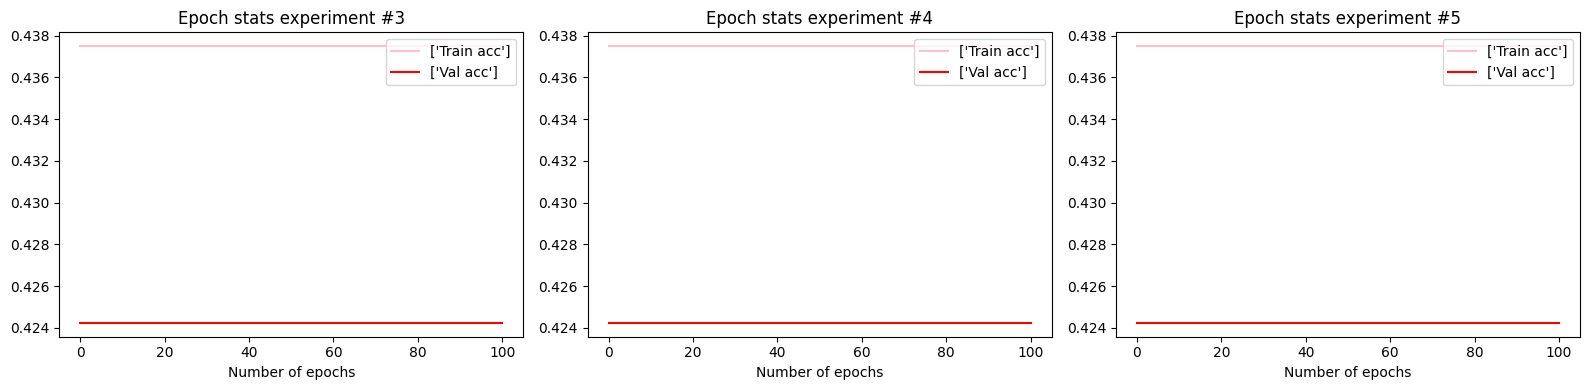

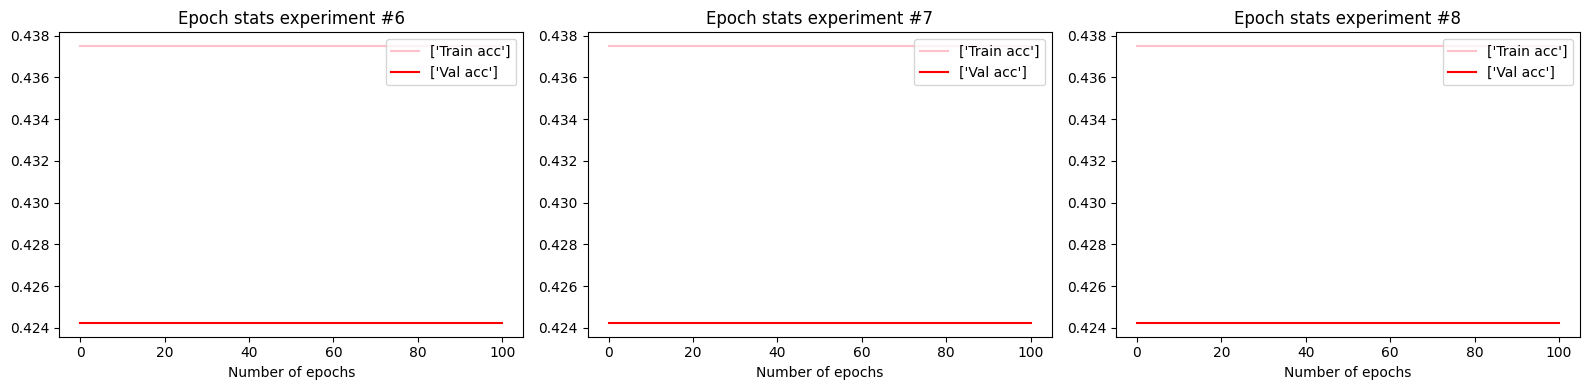

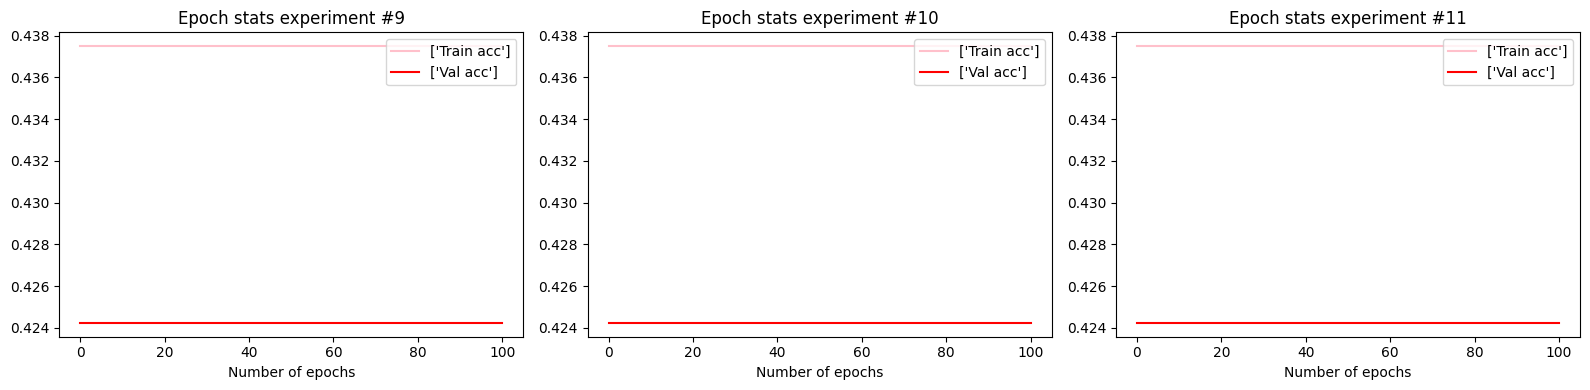

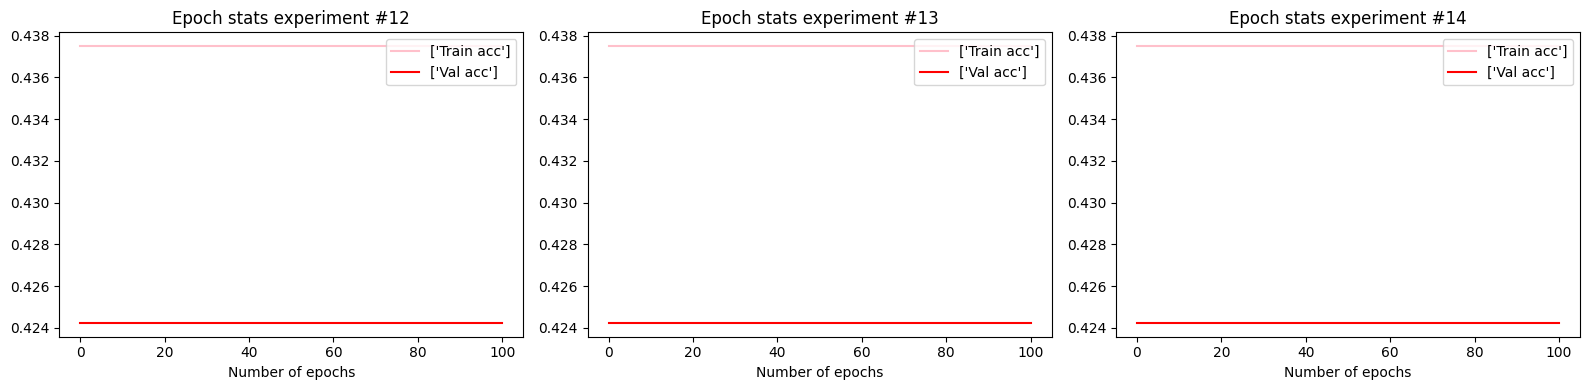

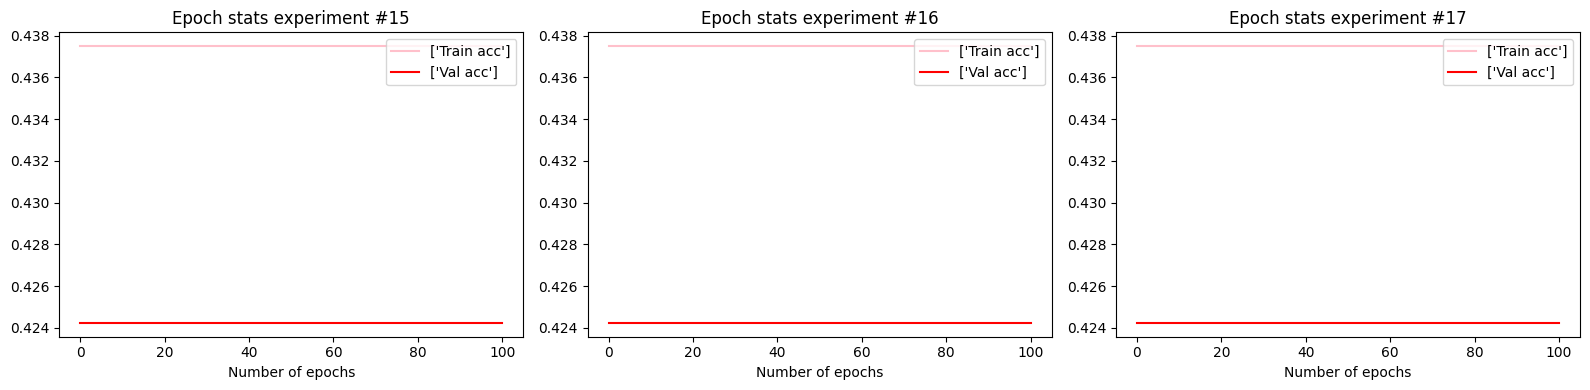

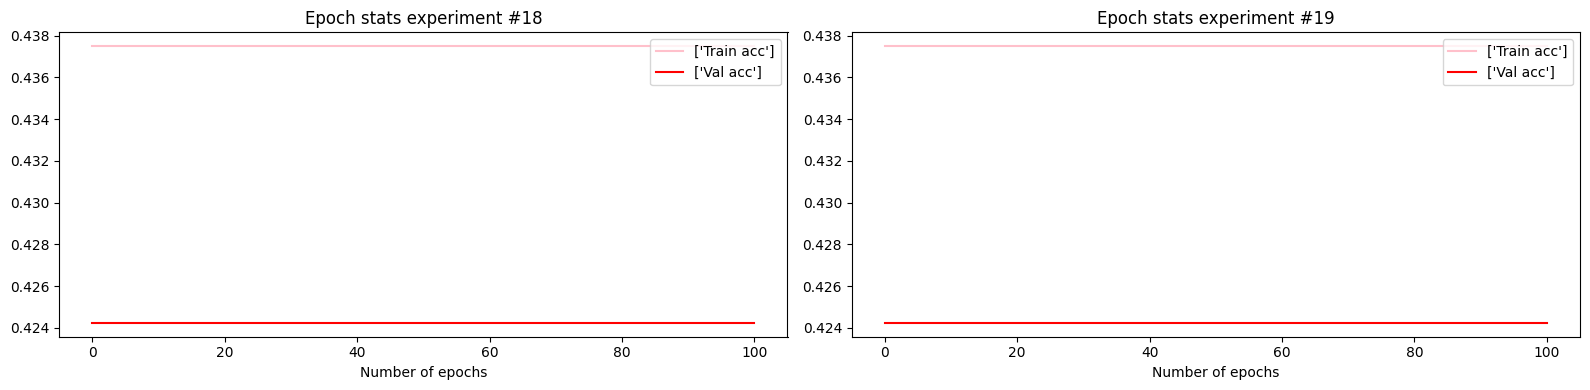

In [42]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

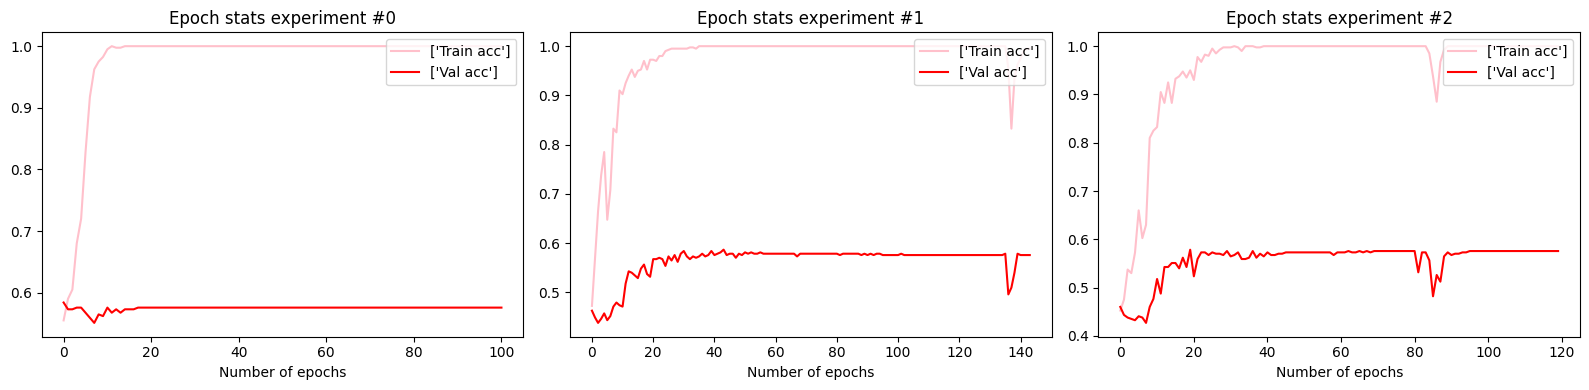

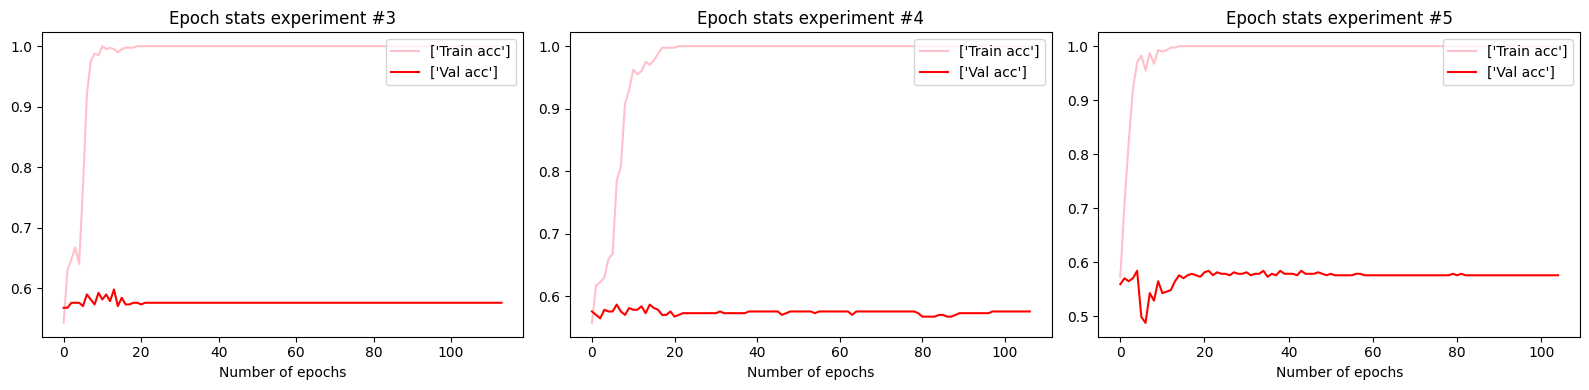

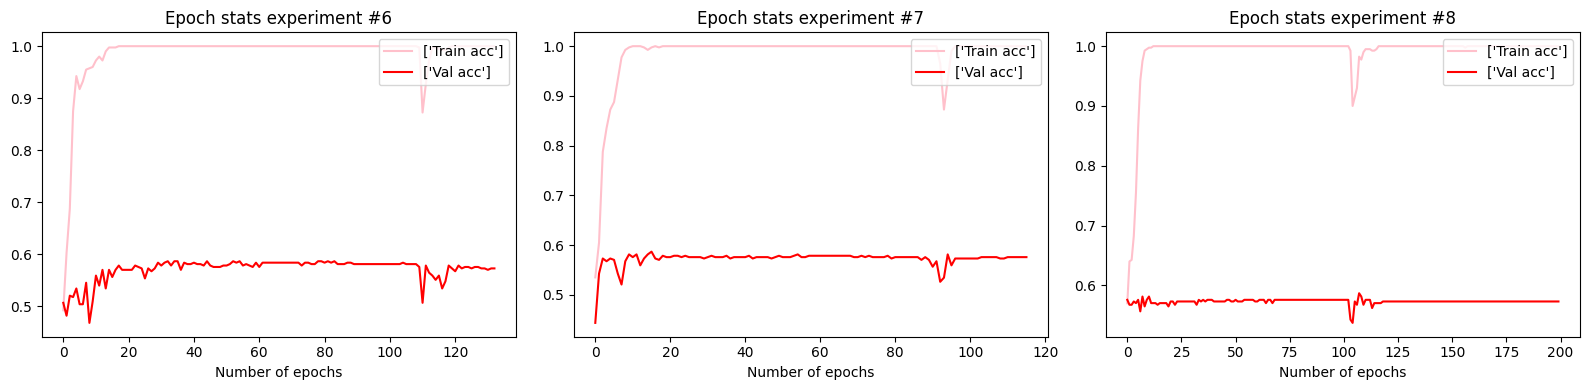

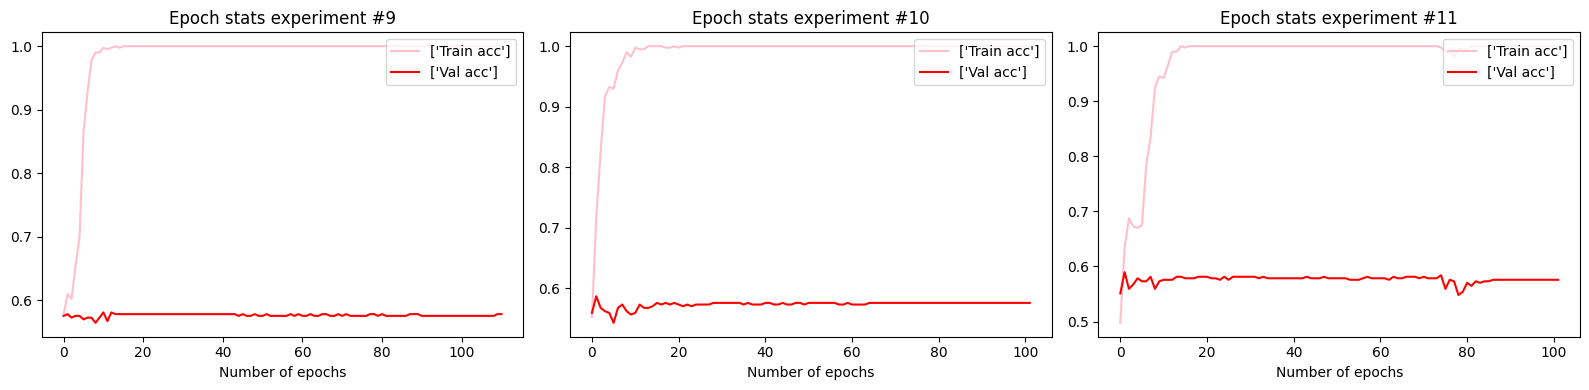

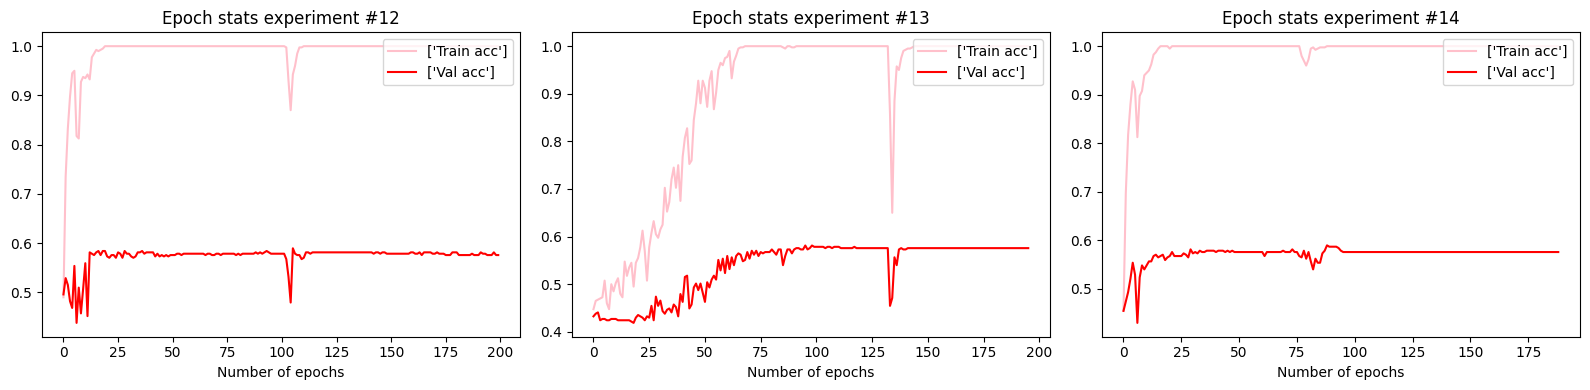

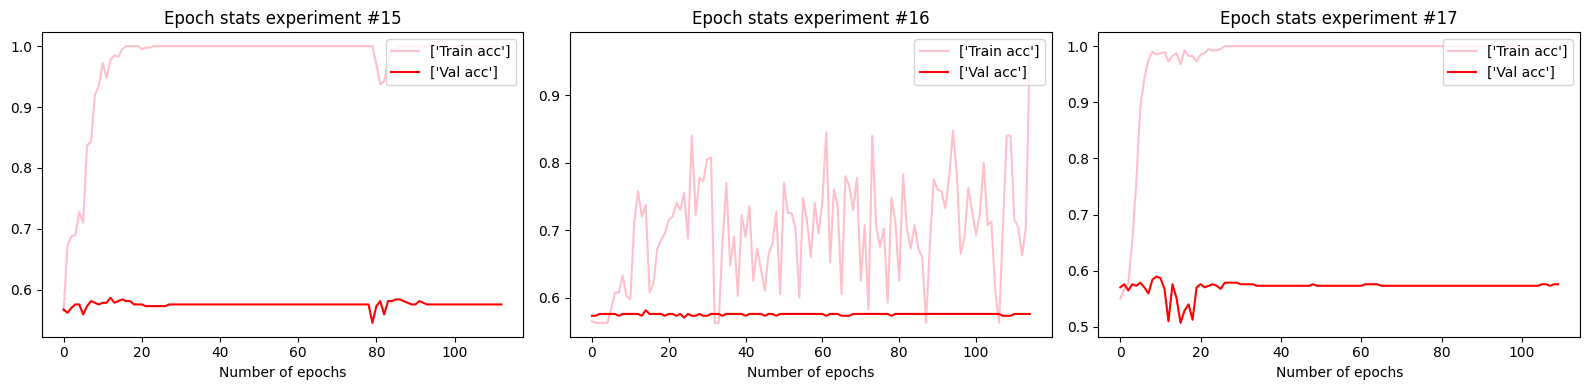

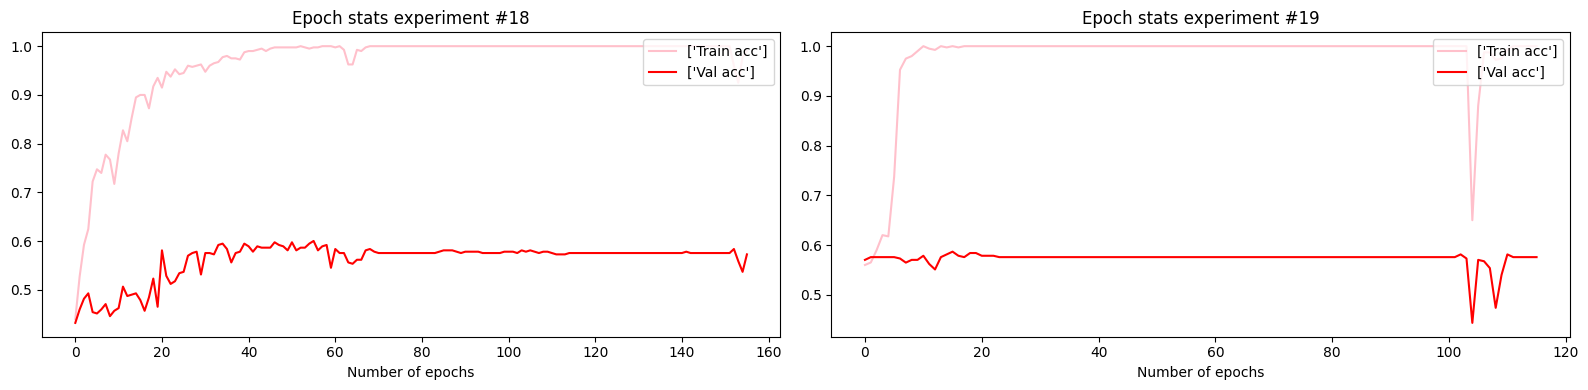

In [43]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [47]:
best_cnn_model = CNN_Model(data, 64, 128, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('best_CNN_model_2nd_interval'))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('best_DEEPSET_model_2nd_interval'))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('best_DEEPSETV2_model_2nd_interval'))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('best_FEEDFORWARD_model_2nd_interval'))
best_lstm_model = LSTM_Model(data, 16, 16, 8).to(device)
best_lstm_model.load_state_dict(torch.load('best_LSTM_model_2nd_interval'))


C:\Users\franm\AppData\Local\Temp\ipykernel_21832\2053327204.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_cnn_model.load_state_dict(torch.load('best_CNN_model_2n

RuntimeError: Error(s) in loading state_dict for LSTM_Model:
	size mismatch for densef1_1.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for densef1_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef2_1.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for densef2_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef3_1.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for densef3_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef1_2.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).
	size mismatch for densef2_2.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).
	size mismatch for densef3_2.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).

## Top wrong predictions for best performing CNN model

In [48]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

Top 10 false positives: 

._.,___.,..wu... ,,,..,dr_.___,,, | label: False | actual prediction: 0.9577748775482178
._,,.,_,._.wu.,. _..,_dr_,..,.,__ | label: False | actual prediction: 0.9517322182655334
,._..wu,.._.,_,. .__._dr...,._,,_ | label: False | actual prediction: 0.9505024552345276
.,_,_,wu_...,,,, ,_,_,_.,dr._._,. | label: False | actual prediction: 0.9495416283607483
____,.__._,..wu. __,,,._dr,_.,_., | label: False | actual prediction: 0.9464691281318665
__,..,wu_.,,._,_ ._,._dr__,.,,_._ | label: False | actual prediction: 0.9362133145332336
.,.,._.____,,wu_ _,_._dr_,,,,..._ | label: False | actual prediction: 0.9359242916107178
.,,_,,_,,_wu..._ _,_,__,_dr_..,._ | label: False | actual prediction: 0.9216526746749878
__,.,_,.wu,,,,__ _,.,.,dr__..__., | label: False | actual prediction: 0.9202376008033752
.__.,..,,.wu__,. __..__dr.,____,. | label: False | actual prediction: 0.9169303774833679

Top 10 false negatives: 

,,_,..,._,__.._. ._.__._,.,_,,_dr | label: True | actual 

## Top wrong predictions for best performing LSTM model

In [49]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

.,,.,_.___.,_.wu ..___,._._,.__r_ | label: True | actual prediction: 0.4116106331348419
,,,..__.__,.wu__ __.._...______r, | label: True | actual prediction: 0.41547879576683044
,_,_,._._,,wu,.. ..,_____,_..._r_ | label: True | actual prediction: 0.41737058758735657
_,..,,_,,...uw__ .,,,...,..,,_.,r | label: True | actual prediction: 0.4177466332912445
.,_._.___,__,uw. .,._,,_,_._.__.r | label: True | actual prediction: 0.42145684361457825
.__,._.,._wu.,._ _.,..,_.,.,.,_.r | label: True | actual prediction: 0.4217628240585327
.,__._,...uw____ ,,.,,,.,._.._.r. | label: True | actual prediction: 0.4241744577884674
__.,.wu,__,,,.,. ._,.,.__,.__.,.r | label: True | actual prediction: 0.4244958162307739
__,__,uw,_,_,_,_ ,,..,,_.____,_r_ | label: True | actual prediction: 0.42523321509361267
_.,._,,.,,_..wu. ,__,___,..,,,__r | label: True | actual prediction: 0.4253748059272766




## Top wrong predictions for best performing DeepSets V1 model

In [50]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

_._.__,uw__.,_,, .._..,.cr...,._. | label: False | actual prediction: 0.6664733290672302
._,__.,,,.,.,uw. .__,._,_,_.__.,. | label: False | actual prediction: 0.6632358431816101
.,.,_._,,_.,,,,. ...,.,,__.,._.,. | label: False | actual prediction: 0.6599212288856506
_,_,_,uw.,.,,.., ,.__...___,.,.,. | label: False | actual prediction: 0.6597945690155029
,....,,___.,_.__ .._..,_____.,.__ | label: False | actual prediction: 0.6554362177848816
_____..,uw....., __,_.,._._.__._. | label: False | actual prediction: 0.6517899036407471
._,,,,,,__.__,,. ___,.cr,.,,_,._, | label: False | actual prediction: 0.6513159275054932
_,.____wu_,.._,, ___.,,.,__._..,_ | label: False | actual prediction: 0.6500067710876465
.,_,,.w,,__,..,, __.,..,,._.,.... | label: False | actual prediction: 0.6497293710708618
,.,,..__,._,____ ._.,,,._._..,_,_ | label: False | actual prediction: 0.6489649415016174

Top 10 false negatives: 

,,__,_,._,uw._,. _,,._,..dr.,_,., | label: True | actual 

## Top wrong predictions for best performing DeepSets V2 model

In [51]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

_._.__,_.,.,,uw. .,__.._dr_._,,,. | label: True | actual prediction: 0.5
._...,,__..w._.. __._...,_.dr,__. | label: True | actual prediction: 0.5
_,,,..wu,,_.,.,. _.___,,._,__r,.. | label: True | actual prediction: 0.5
_..__w.,._.,_,,. .,,,.._r,,,_.._, | label: True | actual prediction: 0.5
,._.._,_____w__, ___,.r,,._...,_, | label: True | actual prediction: 0.5
__.__,.,.,_._,., ,__,,.__r._,.,__ | label: True | actual prediction: 0.5
._,.._,___.w,,., __.,__,.r..,_,_. | label: True | actual prediction: 0.5
_.__,.___,,.,,_. ,.,.,_.dr,....__ | label: True | actual prediction: 0.5
____,wu.,,_.,,.. __,,.,r.......__ | label: True | actual prediction: 0.5
.,,,_,__,,_wu,., ,,,,,.__,_r_._., | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [52]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

._,__.,,,.,.,uw. .__,._,_,_.__.,. | label: False | actual prediction: 0.6926551461219788
.,_,,.w,,__,..,, __.,..,,._.,.... | label: False | actual prediction: 0.6903913021087646
__,_,..__,_.uw.. __,,..,,.,,__,_. | label: False | actual prediction: 0.6766291856765747
_.___,__.....,., ,_._._....,,_.._ | label: False | actual prediction: 0.672842264175415
.,_,_,.__w,..,,_ _.,_._,..,.,..,. | label: False | actual prediction: 0.6685575246810913
.,,_,.._,.,,___, ._._,,,,.cr,,,.. | label: False | actual prediction: 0.6636224389076233
,__,._,_..__,._, .___..,.___,_... | label: False | actual prediction: 0.6572622656822205
..,,_,.wu..._._. _._,_.,__cr_..__ | label: False | actual prediction: 0.6565334796905518
._,._.,_w_,.__,, _,.,.._,.,,.,,.. | label: False | actual prediction: 0.6539177298545837
_____..,uw....., __,_.,._._.__._. | label: False | actual prediction: 0.6537409424781799

Top 10 false negatives: 

,,__,_,._,uw._,. _,,._,..dr.,_,., | label: True | actual p

# Saving Notebook State

In [ ]:
import dill
dill.dump_session('notebook_env_first_third.db')

# Loading Notebook State

In [ ]:
import dill
# dill.load_session('notebook_env_first_third.db')